In [26]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
import constants
import os
from statistics_methods.Statistics import StatisticsWrapper
from statistics_methods.plots import PlotsManager
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster
import wandb

Constants

In [27]:
chosen_rois_dict = constants.ROI_CORTEX
params_to_work_with = constants.ALL_PARAMS

Load the data and proccess it

In [28]:
def load_data(data_path):
    subjects_raw_data = DataProcessor(data_path, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_mean_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

    group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
    young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data, col_divider, threshold)

    return chosen_data, young_subjects, old_subjects

In [29]:
chosen_data_raw, young_subjects_raw, old_subjects_raw = load_data(constants.PATH_TO_CORTEX_all_params_raw)
chosen_data_z_score, young_subjects_z_score, old_subjects_z_score = load_data(constants.PATH_TO_CORTEX_all_params_z_score)

In [5]:
DataProcessor.outliers_counter(chosen_data_z_score, params_to_work_with, chosen_rois_dict)

outliers counter: {'H036_EV': 29, 'H047_DC': 17, 'H046_NB': 12, 'H054_AE': 9, 'H030_NS': 7, 'H039_JH': 6, 'H050_AB': 5, 'H023_IN': 5, 'H055_MY': 5, 'H022_YR': 4, 'H048_GA': 3, 'H051_YK': 3, 'H037_YB': 3, 'H028_LC': 2, 'H032_JD': 2, 'H041_VG': 2, 'H042_MS': 2, 'H021_DH': 2, 'H045_PO': 2, 'H031_IN': 2, 'H020_RR': 2, 'H038_GB': 2, 'H034_HB': 1, 'H052_OF': 1, 'H040_RK': 1, 'H043_OS': 1, 'H044_AZ': 1, 'H026_LY': 1, 'H025_SH': 1, 'H033_MB': 1, 'H049_SV': 1, 'H019_AF': 1, 'H018_AS': 1, 'H061_SE': 1}


Check raw data variations

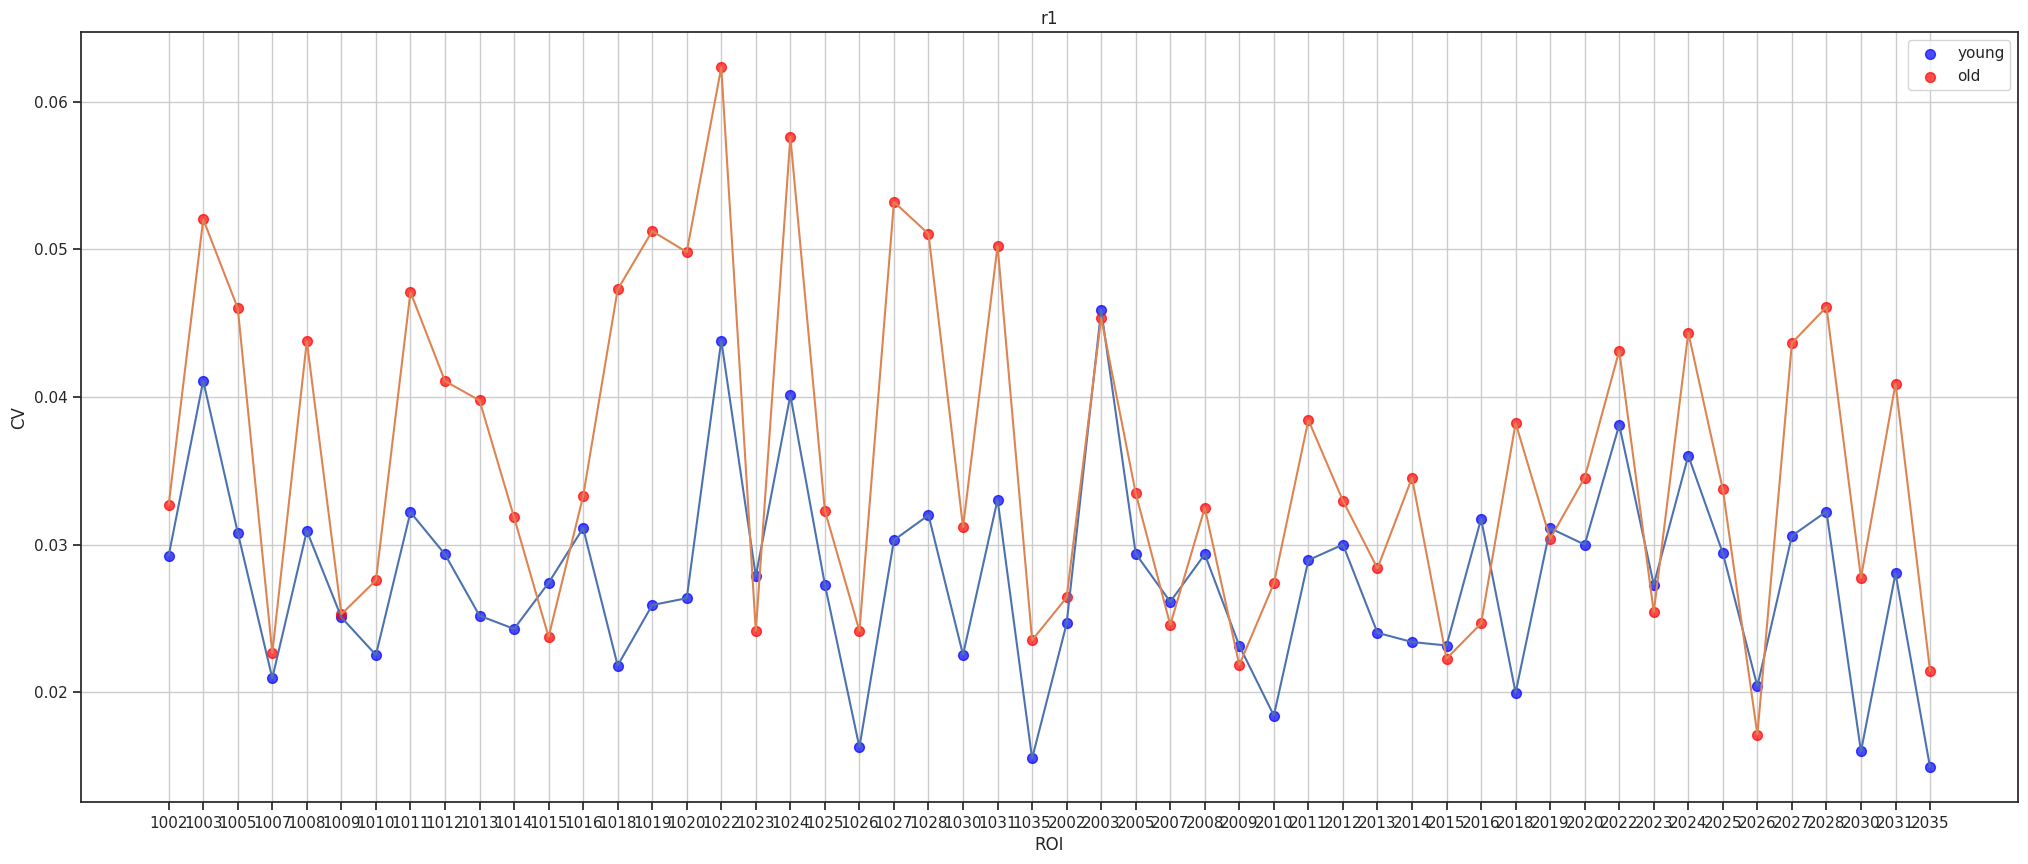

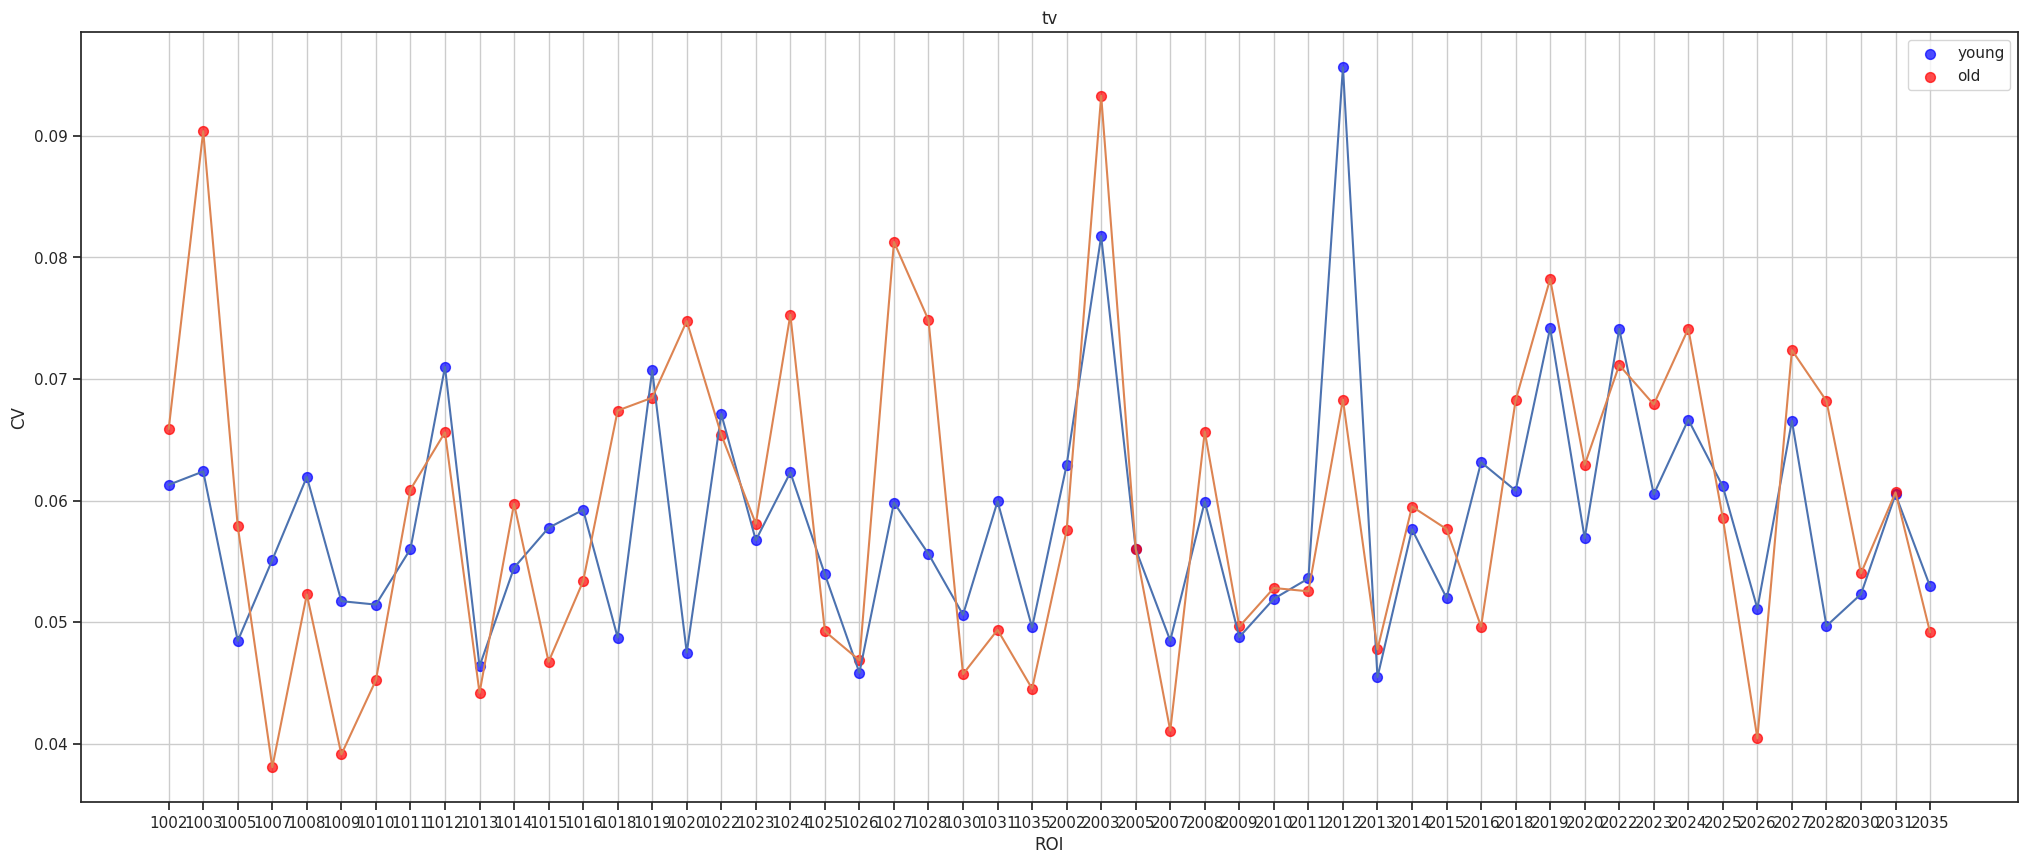

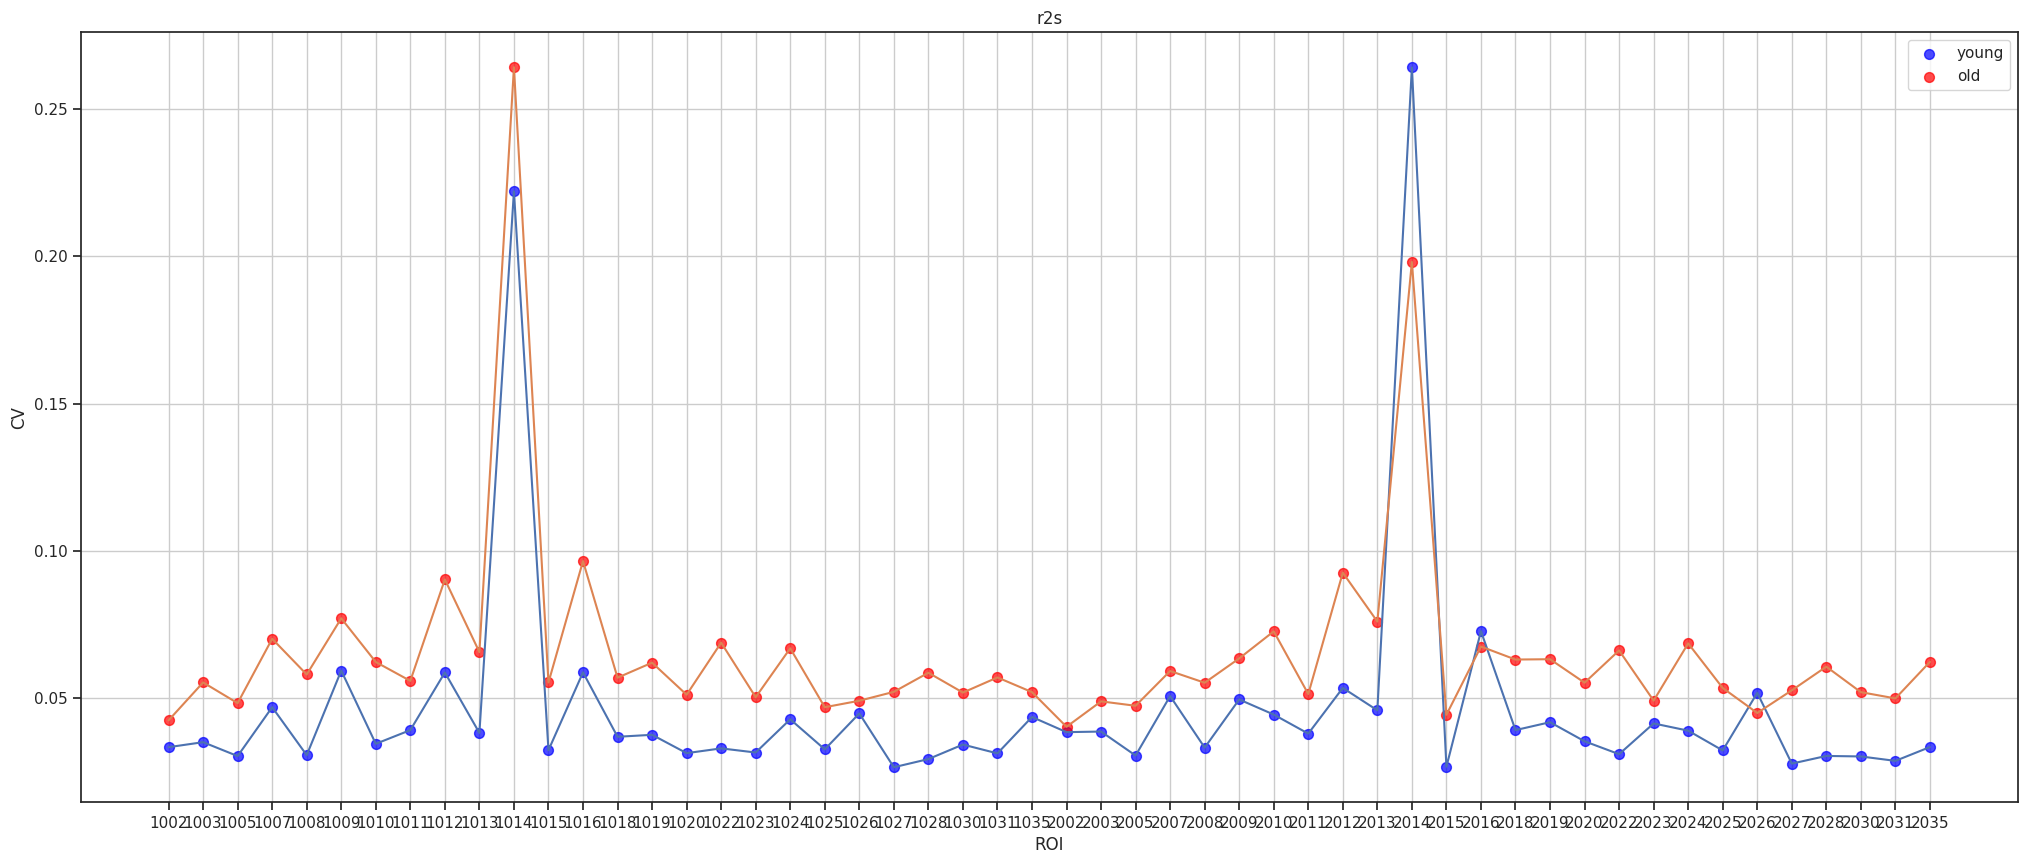

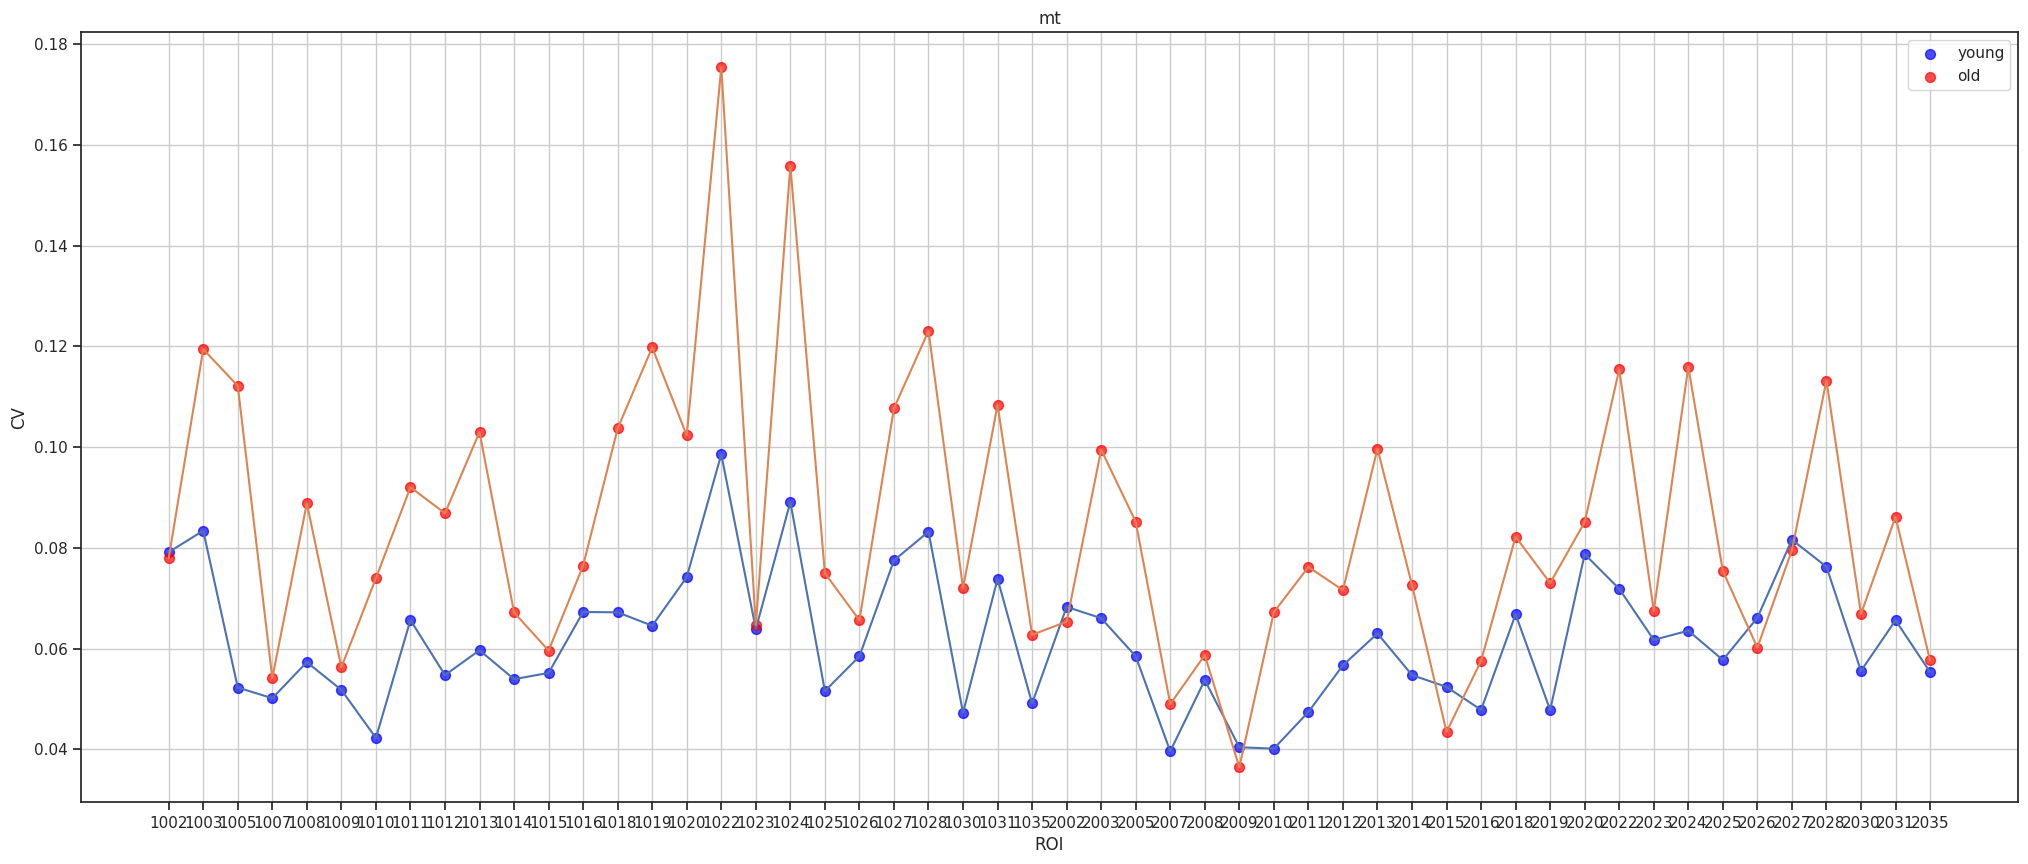

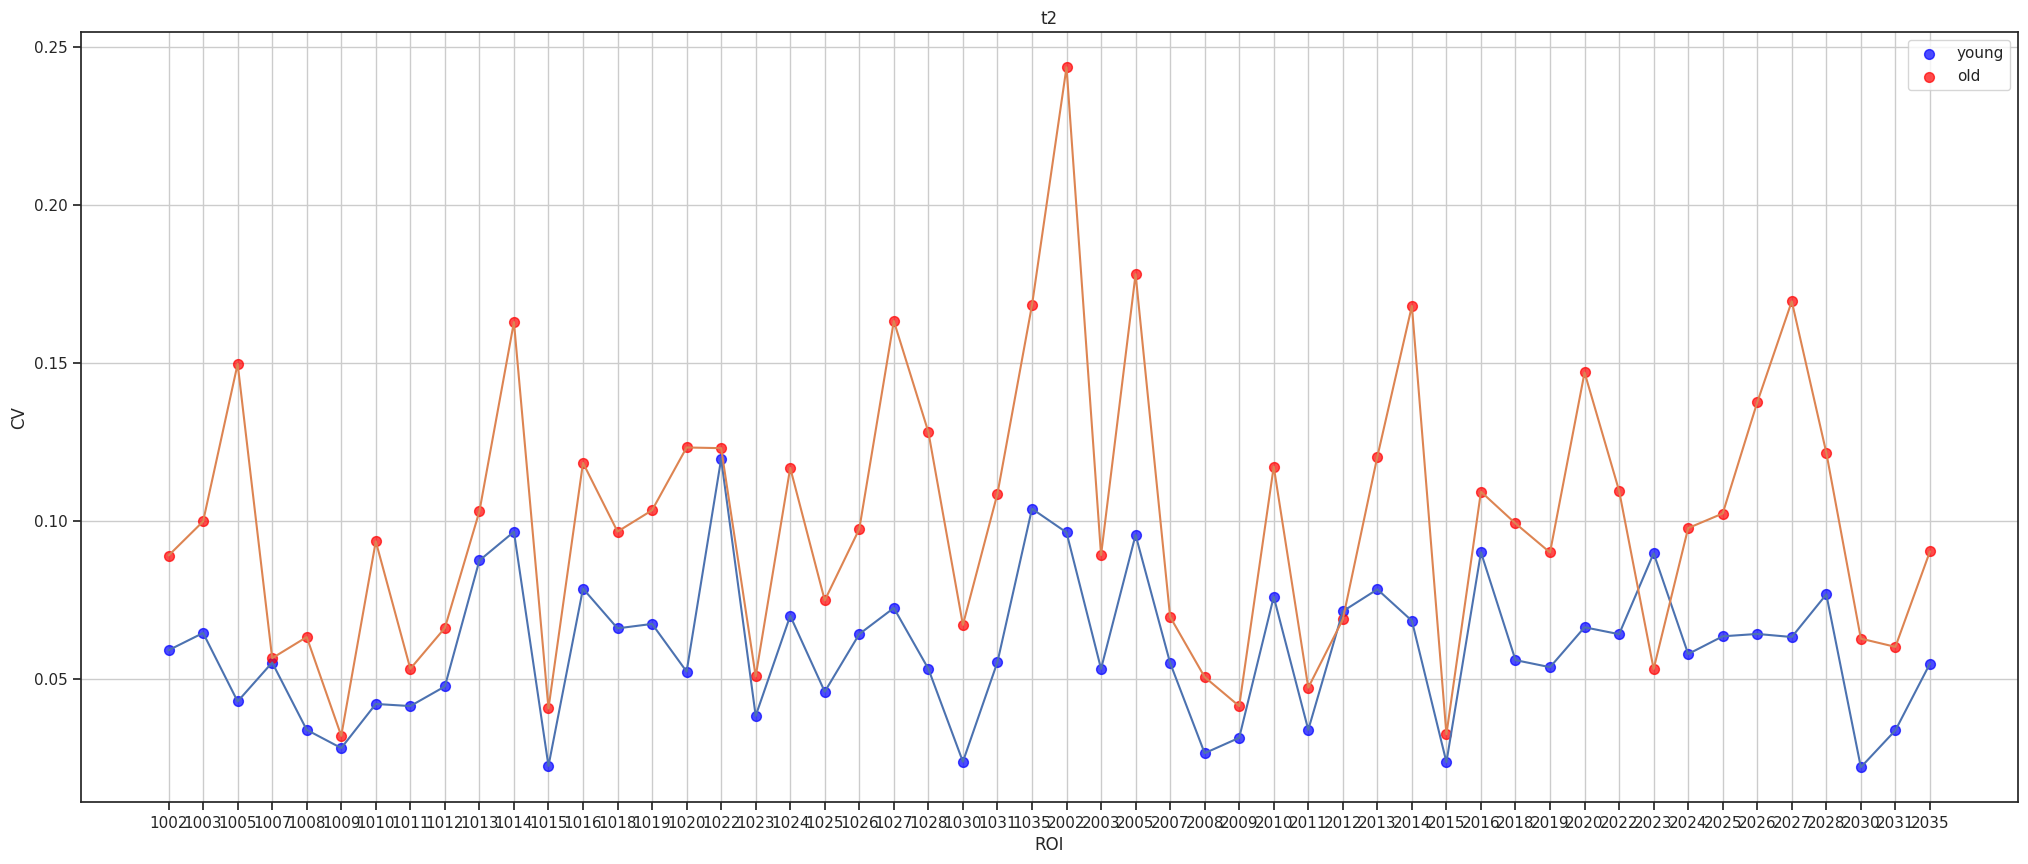

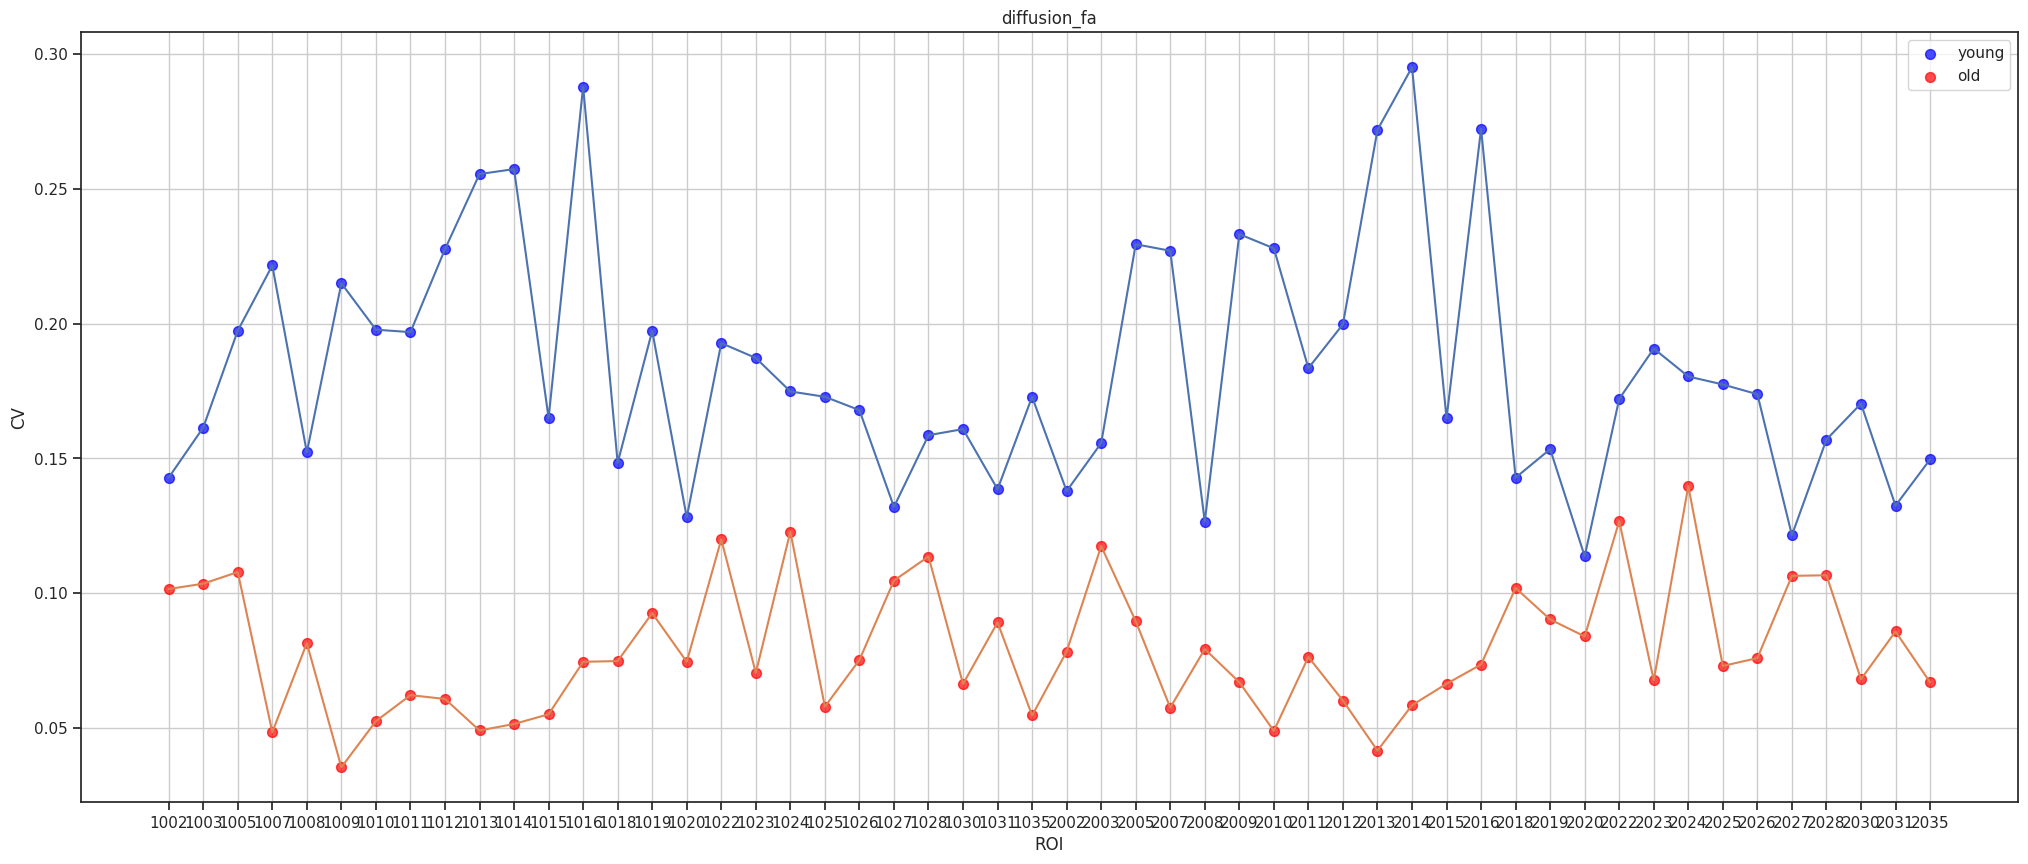

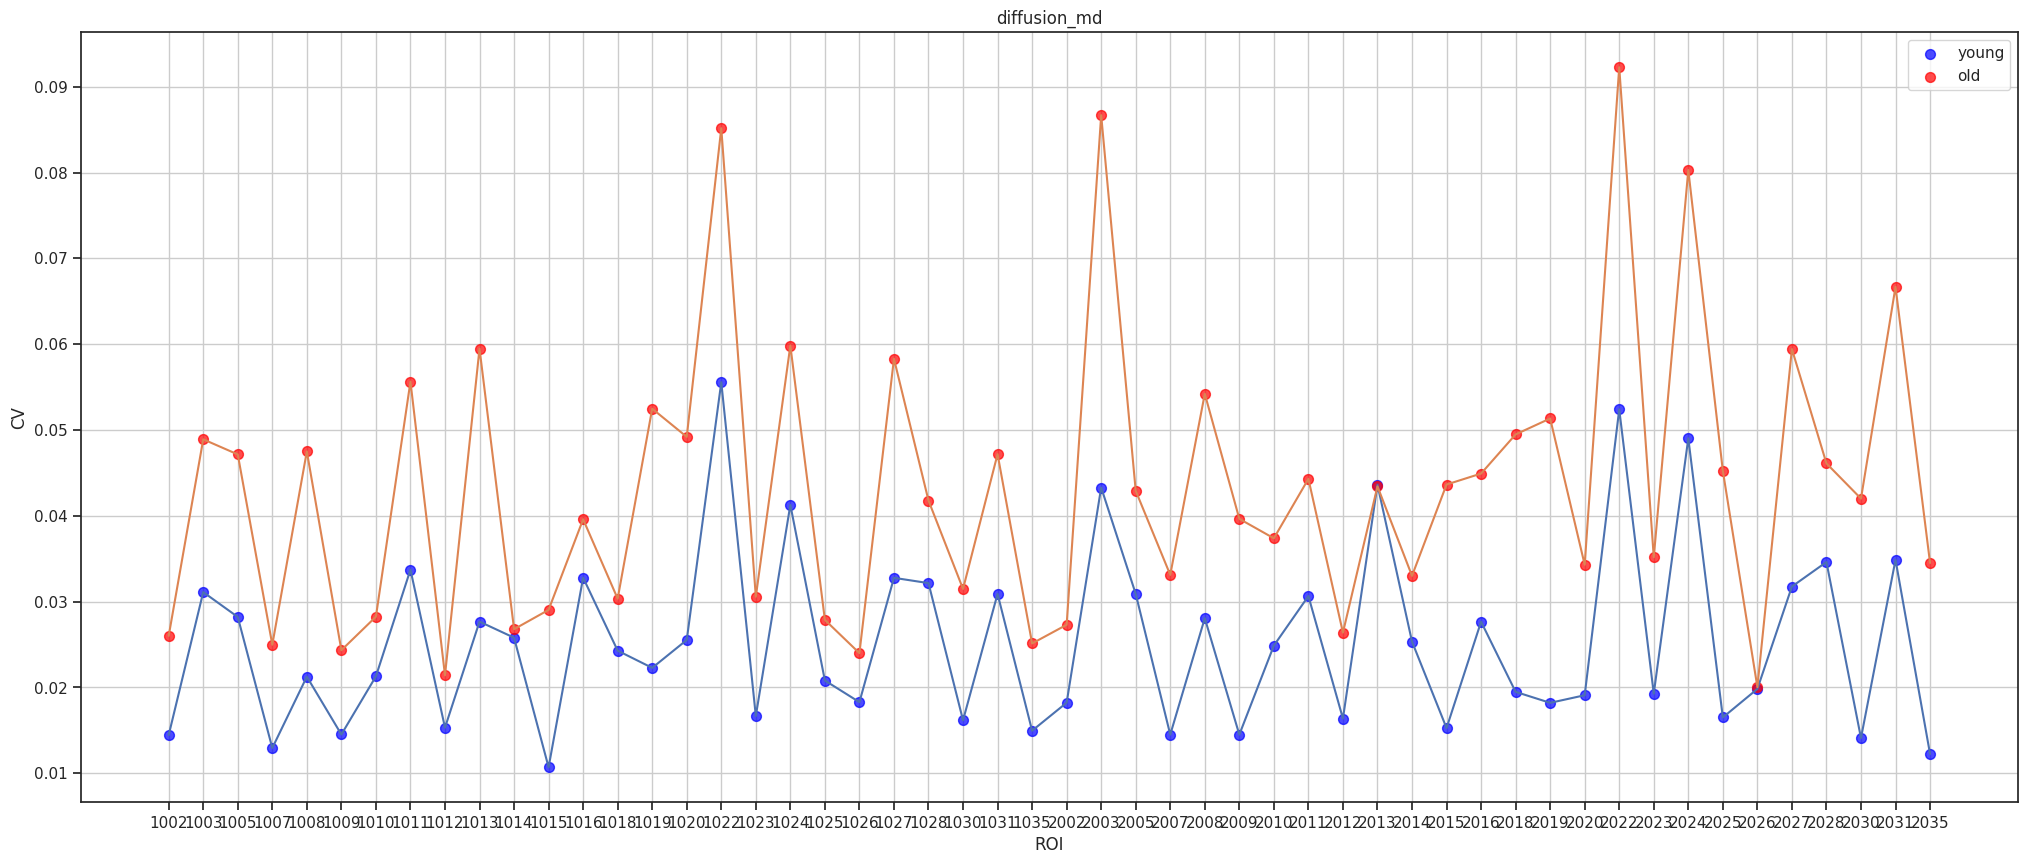

In [5]:
group_by_param = 'ROI'
x_axis = 'ROI'
data_groups = [(young_subjects_raw, 'blue', 'young'), (old_subjects_raw, 'red', 'old')]
StatisticsWrapper.calculate_cv_for_subjects(data_groups, group_by_param, params_to_work_with, x_axis, use_reg=False, fig_size=(25, 10), connect_scatter=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


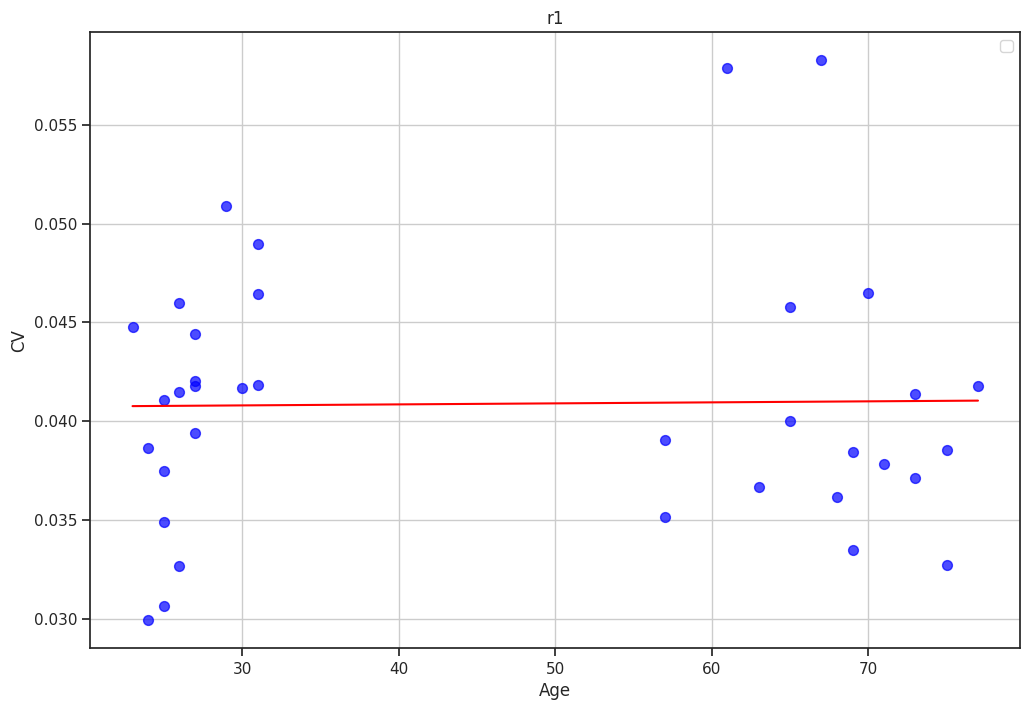

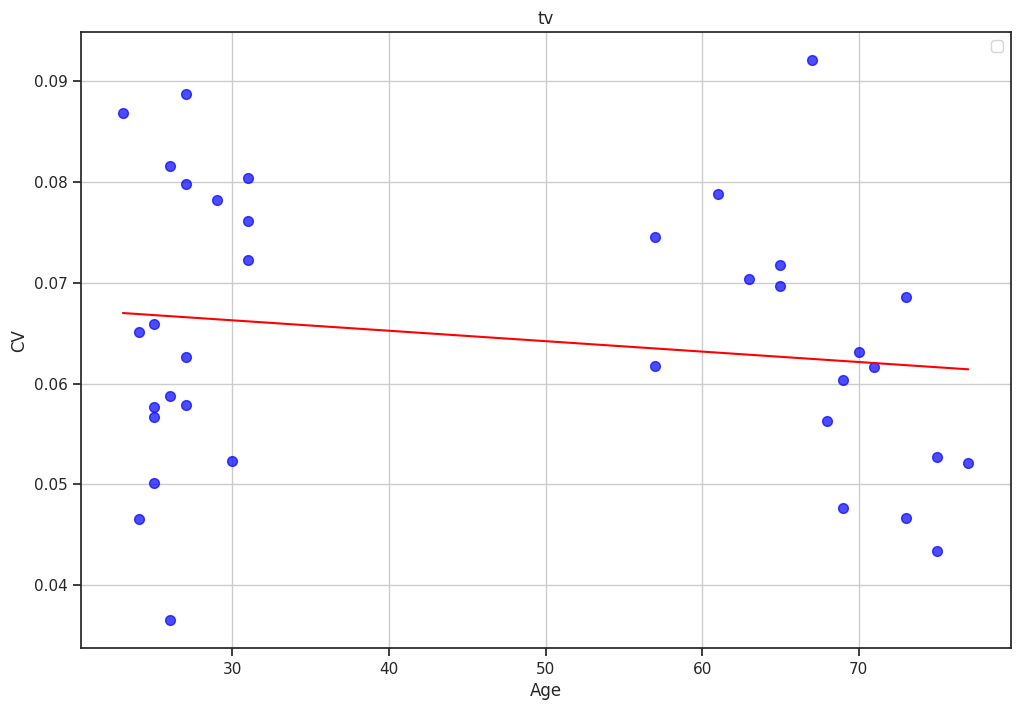

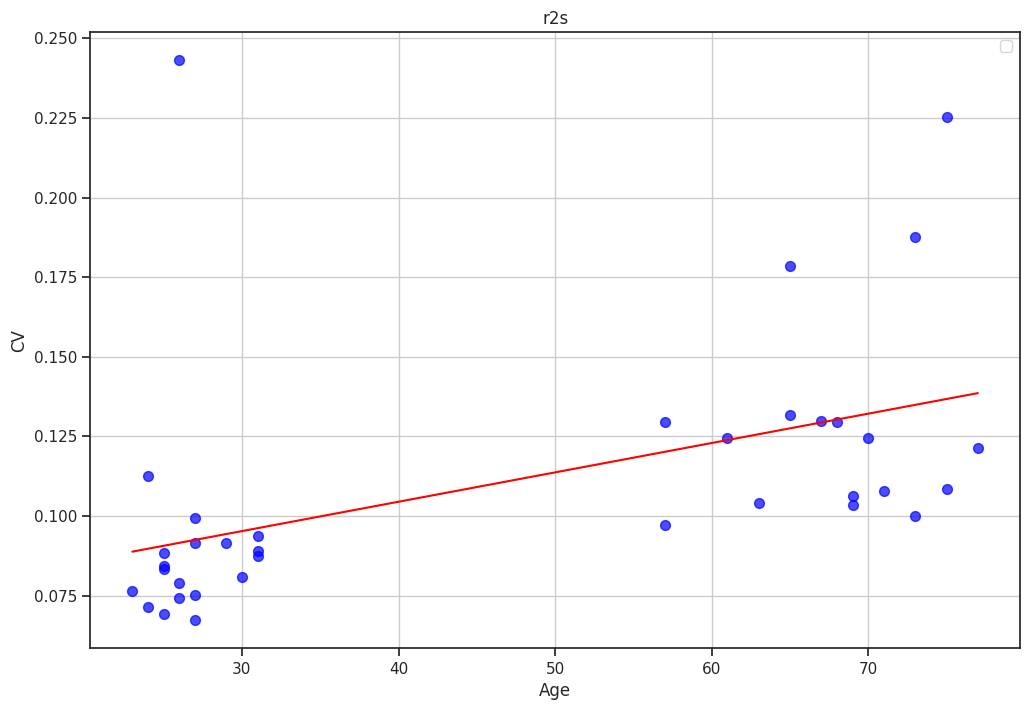

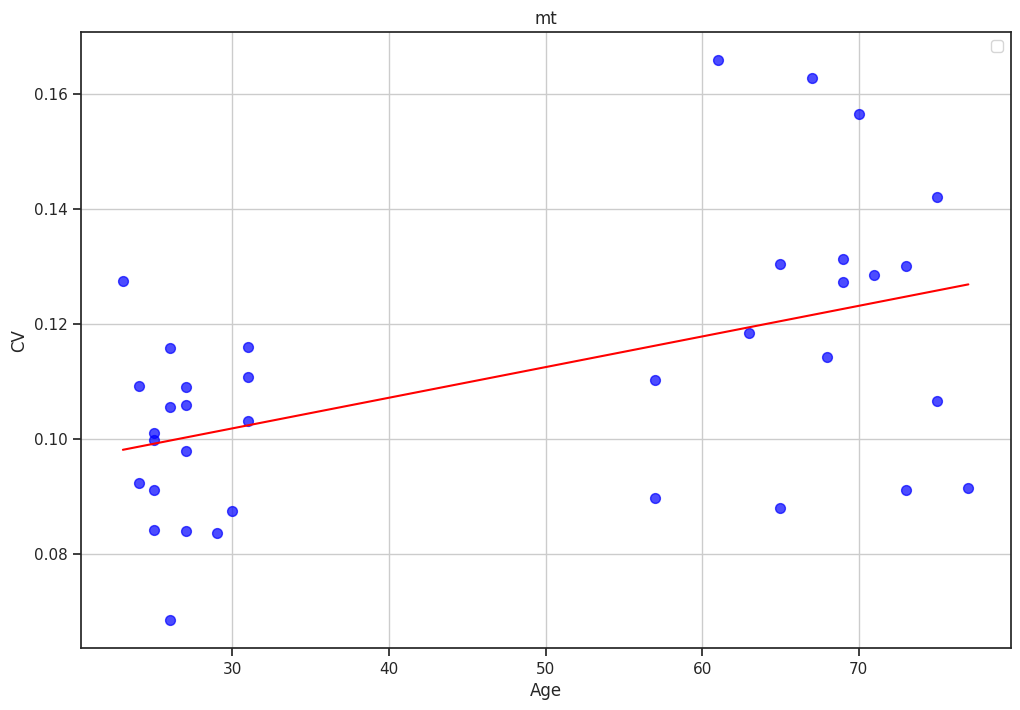

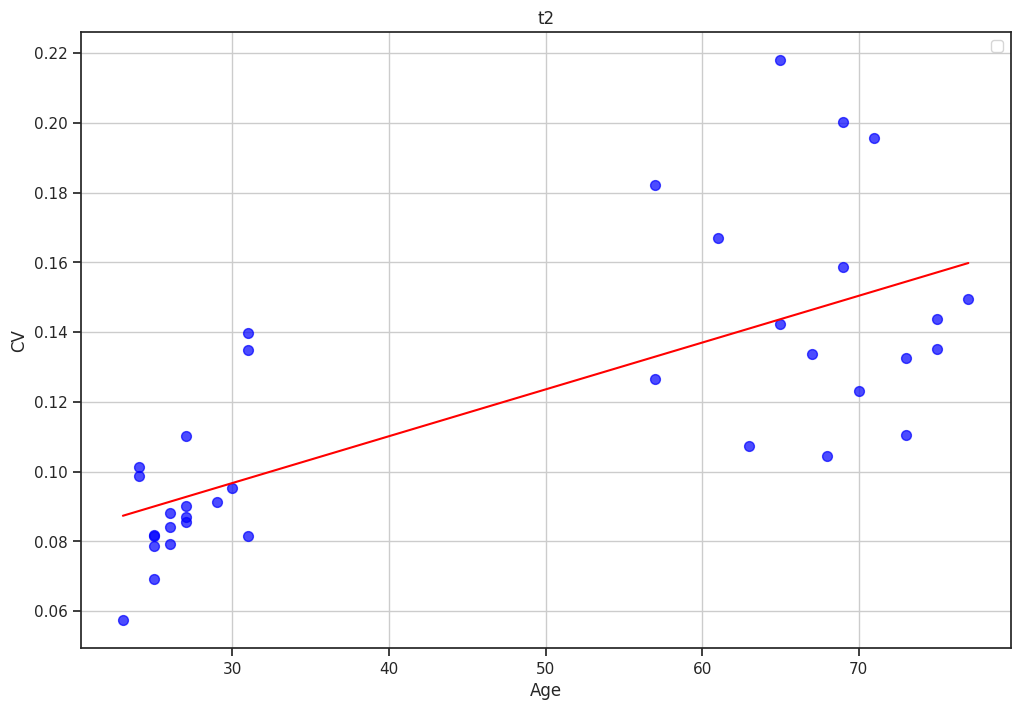

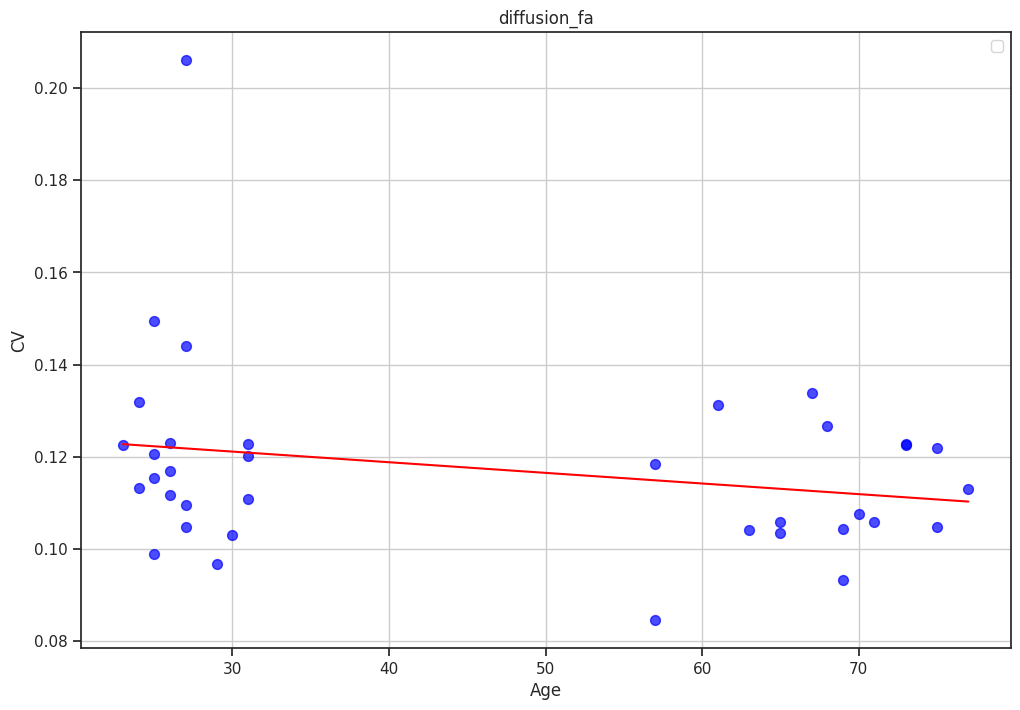

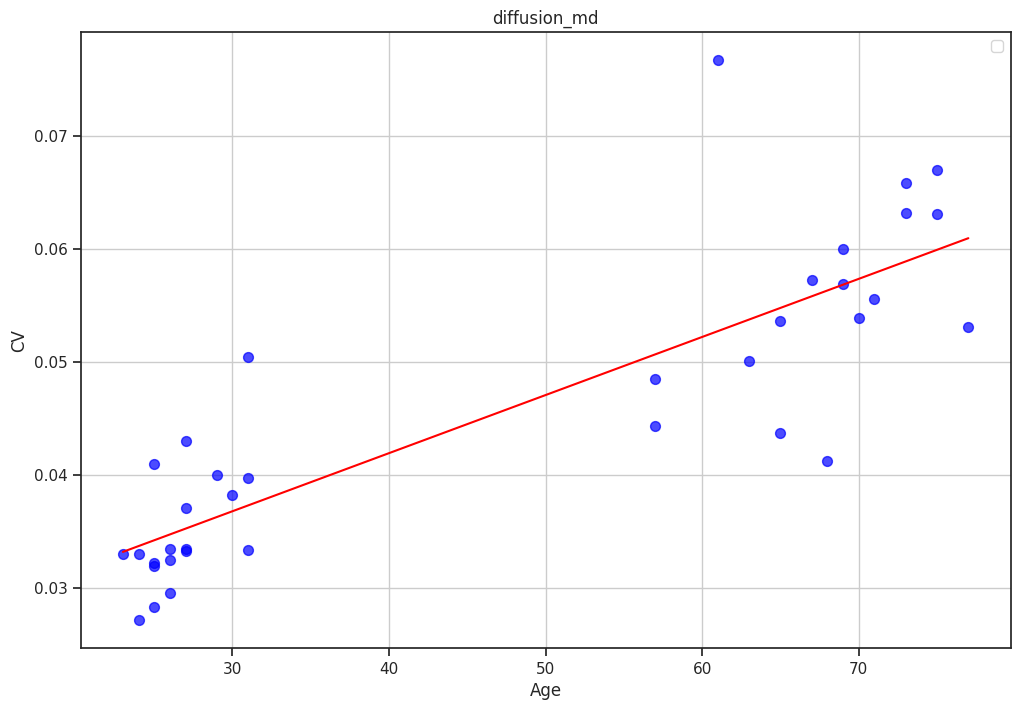

In [30]:
group_by_param = 'subjects'
x_axis = 'Age'
data_groups = [(chosen_data_raw, 'blue', '')]
StatisticsWrapper.calculate_cv_for_subjects(data_groups, group_by_param, params_to_work_with, x_axis, use_reg=True, fig_size=(12, 8))

Check correlations on the normalized data

In [5]:
def show_correlations_stats(all_data, young_data, old_data, method):
    clusters_rois = StatisticsWrapper.hierarchical_clustering(all_data, params_to_work_with, 'single',
                                                                title="all")['dendrogram_data']['ivl']
    young_result = StatisticsWrapper.roi_correlations(young_data, params_to_work_with, clusters_rois,
                                                        'young', method=method)
    old_result = StatisticsWrapper.roi_correlations(old_data, params_to_work_with, clusters_rois, 'old', method=method)

    PlotsManager.plot_heatmap(old_result - young_result, 'differences of old and young', project_name=None)

    young_result['corr_mean'] = young_result.apply(np.mean, axis=1) - 1/young_result.shape[0]
    old_result['corr_mean'] = old_result.apply(np.mean, axis=1) - 1/old_result.shape[0]

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('Average correlations')
    ax.scatter(chosen_rois_dict.values(), young_result['corr_mean'].to_numpy(), color='blue', s=20, alpha=0.7, label='young')
    ax.scatter(chosen_rois_dict.values(), old_result['corr_mean'].to_numpy(), color='red', s=20, alpha=0.7, label='old')
    ax.plot(chosen_rois_dict.values(), young_result['corr_mean'].to_numpy())
    ax.plot(chosen_rois_dict.values(), old_result['corr_mean'].to_numpy())
    ax.legend()
    ax.set_facecolor('white')


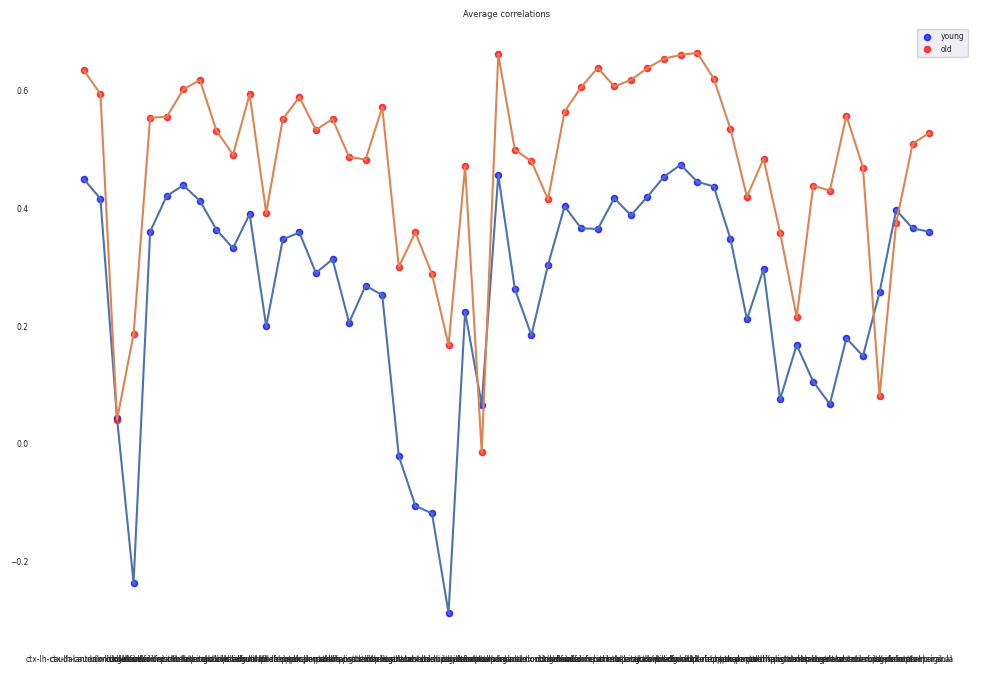

In [9]:
show_correlations_stats(chosen_data_z_score, young_subjects_z_score, old_subjects_z_score, 'pearson')

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code/statistics_methods/Statistics.py:529: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distances, method=linkage_metric)


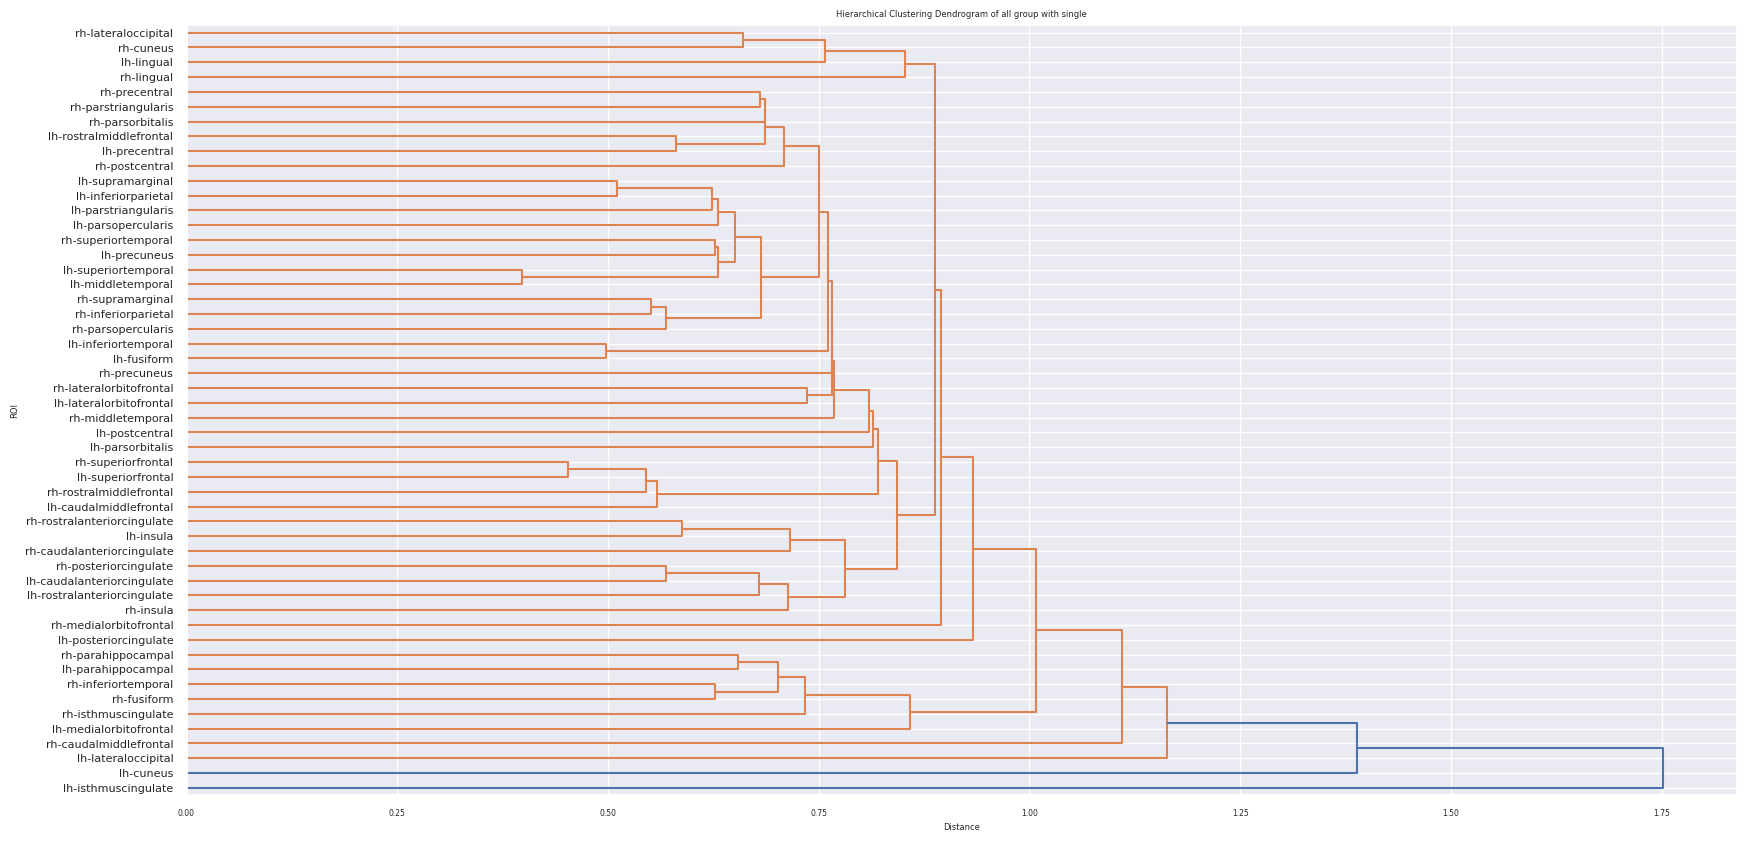

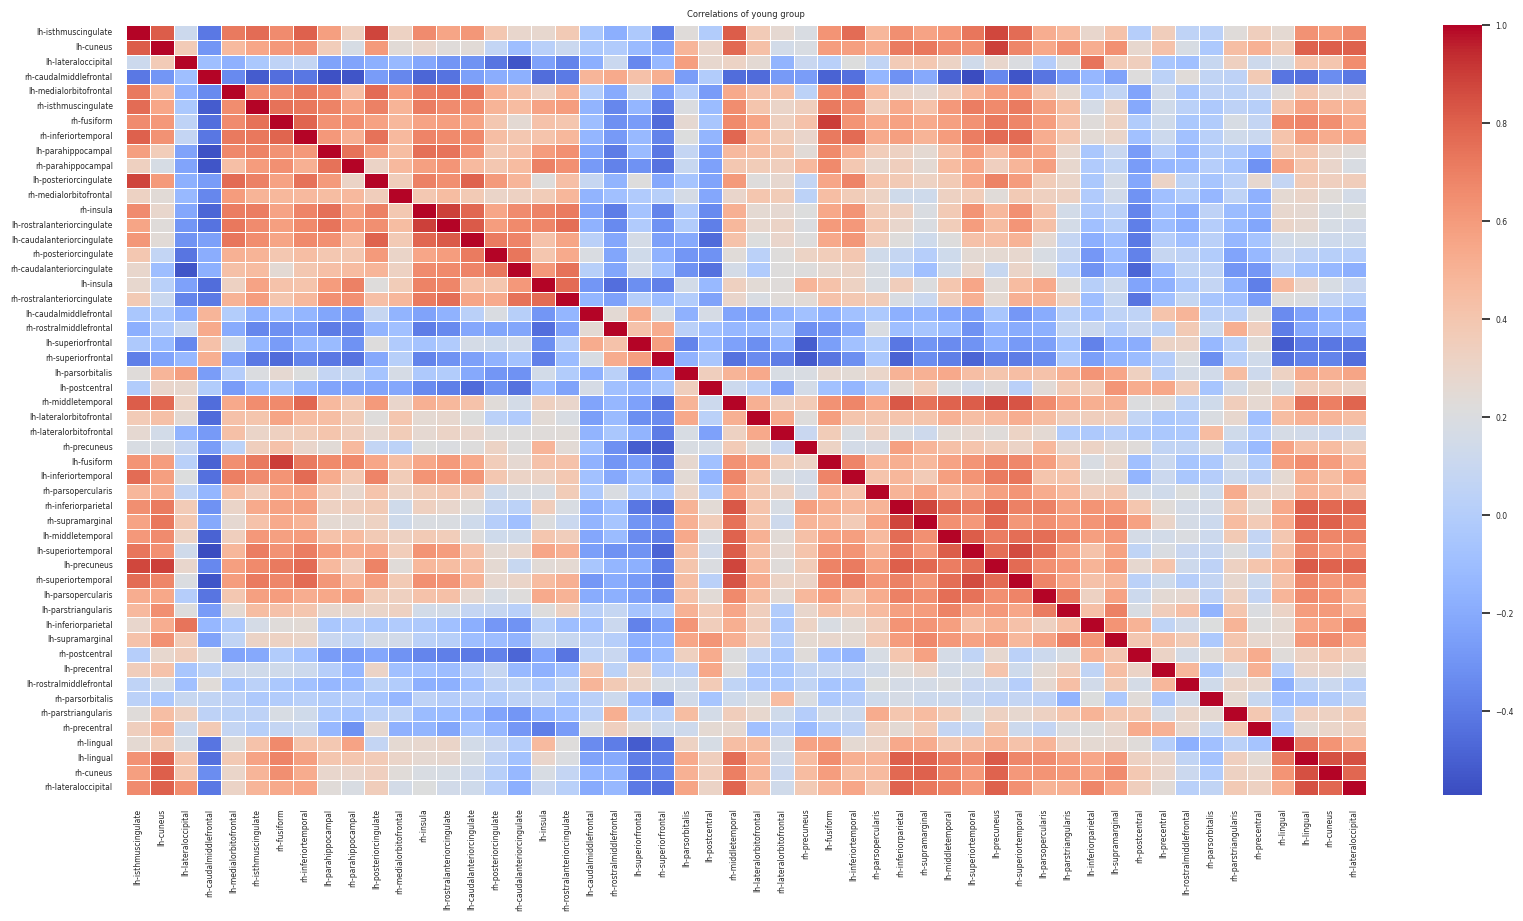

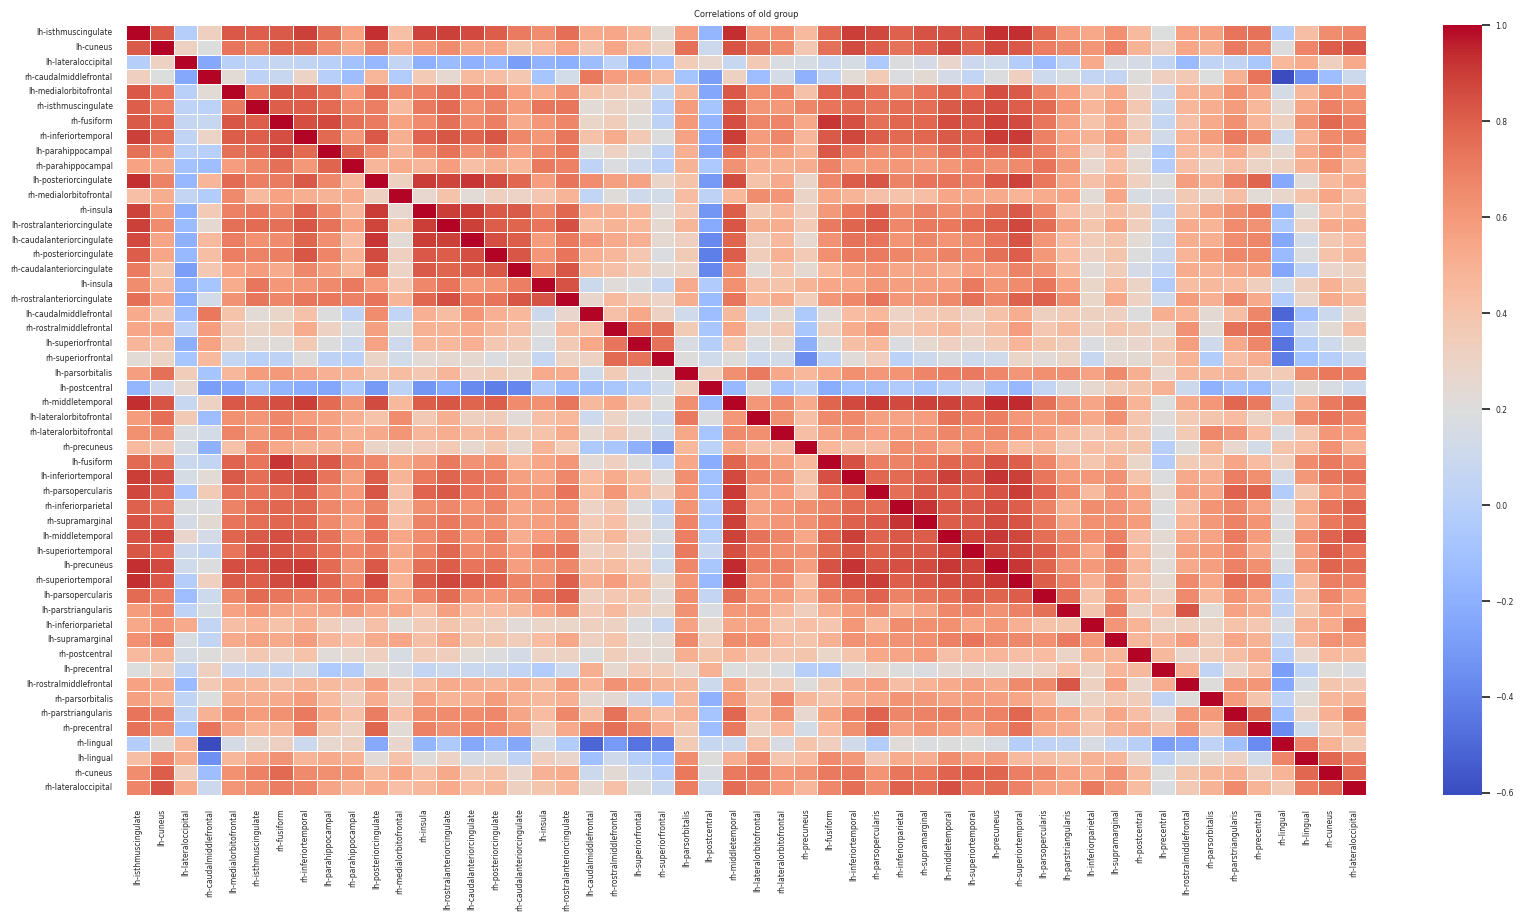

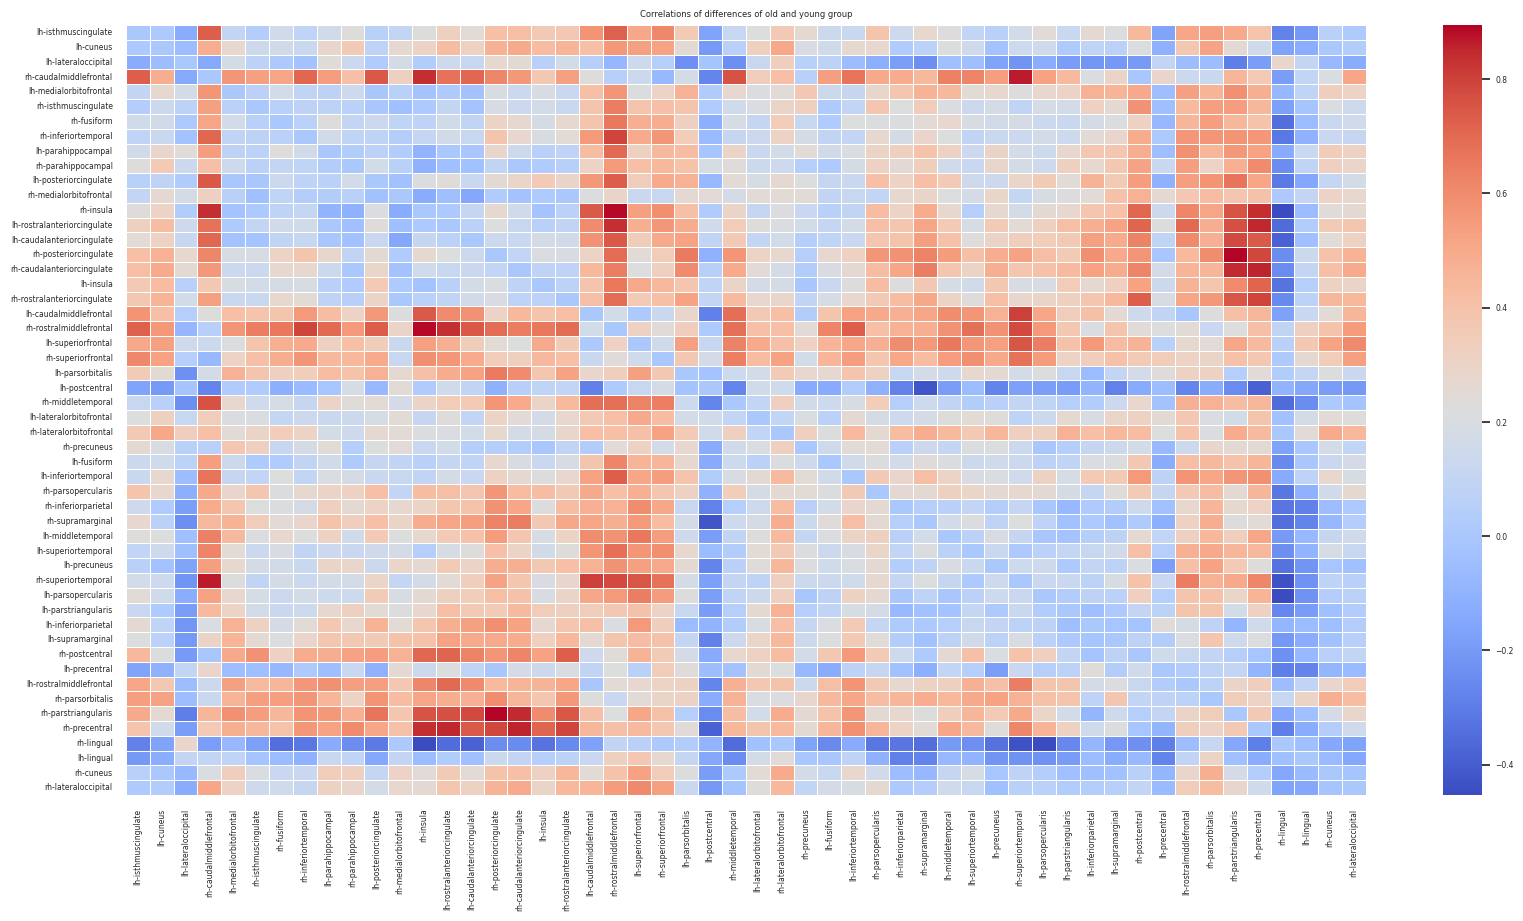

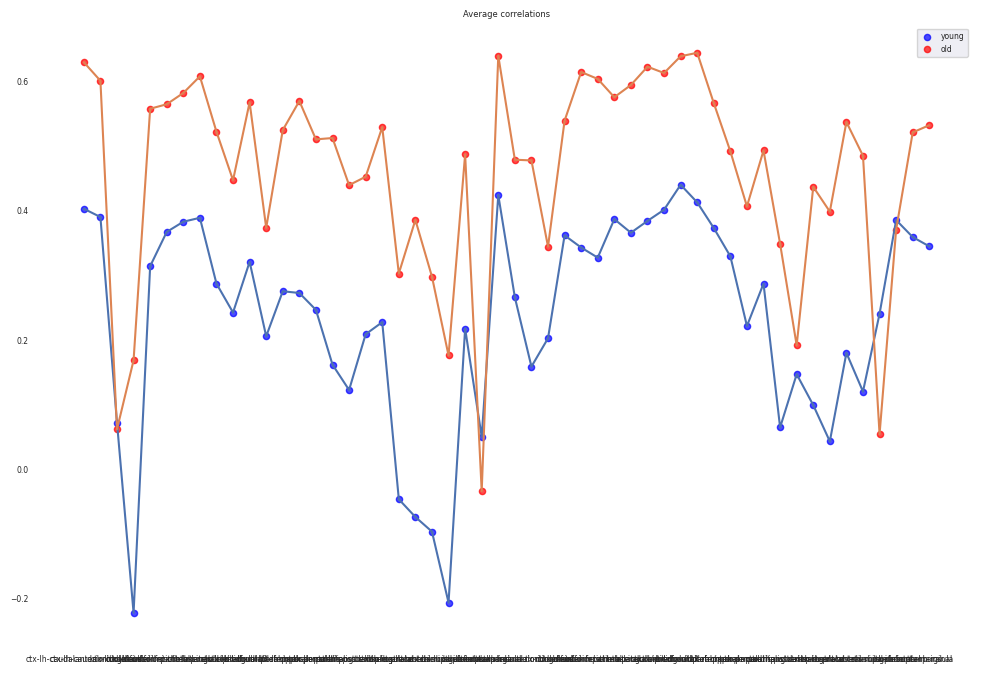

In [8]:
show_correlations_stats(chosen_data_z_score, young_subjects_z_score, old_subjects_z_score, 'spearman')

Check features importance

Check t_test on the young and old groups

In [6]:
StatisticsWrapper.t_test_per_parameter_per_area(young_subjects_z_score, old_subjects_z_score, chosen_rois_dict, 'ROI', params_to_work_with)

param r1 number of areas with significance differences: 38
param tv number of areas with significance differences: 20
param r2s number of areas with significance differences: 20
param mt number of areas with significance differences: 26
param t2 number of areas with significance differences: 30
param diffusion_fa number of areas with significance differences: 22
param diffusion_md number of areas with significance differences: 26


Subjects clustering 

In [19]:
def reduce_dim(model, data):
    res = model.fit_transform(data)

    column_names = [f"var_{i + 1}" for i in range(res.shape[1])]  # Generate dynamic column names
    reduced_data = pd.DataFrame(res, columns=column_names, index=data.index)

    # print(f'kl divergence: {model.kl_divergence_}')
    return reduced_data

In [22]:
young_features_df = pd.pivot_table(young_subjects_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')
old_features_df = pd.pivot_table(old_subjects_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')
data_features_df = pd.pivot_table(chosen_data_z_score, index='subjects', columns='ROI', values=params_to_work_with, aggfunc='sum')

In [9]:
dim = 0.95
pca = PCA(n_components=2)
tsne = TSNE(n_components=2, perplexity=3, random_state=42)
data_reduced_pca = reduce_dim(pca, data_features_df)
data_reduced_tsne = reduce_dim(tsne, data_features_df)
# young_df_reduced = reduce_dim(stage_one_model, young_features_df)
# old_df_reduced = reduce_dim(stage_one_model, old_features_df)

In [10]:
young_df_pca = data_reduced_pca.loc[young_features_df.index]
old_df_pca = data_reduced_pca.loc[old_features_df.index]

young_df_tsne = data_reduced_tsne.loc[young_features_df.index]
old_df_tsne = data_reduced_tsne.loc[old_features_df.index]

Text(0.5, 1.0, 'Subjects t-SNE')

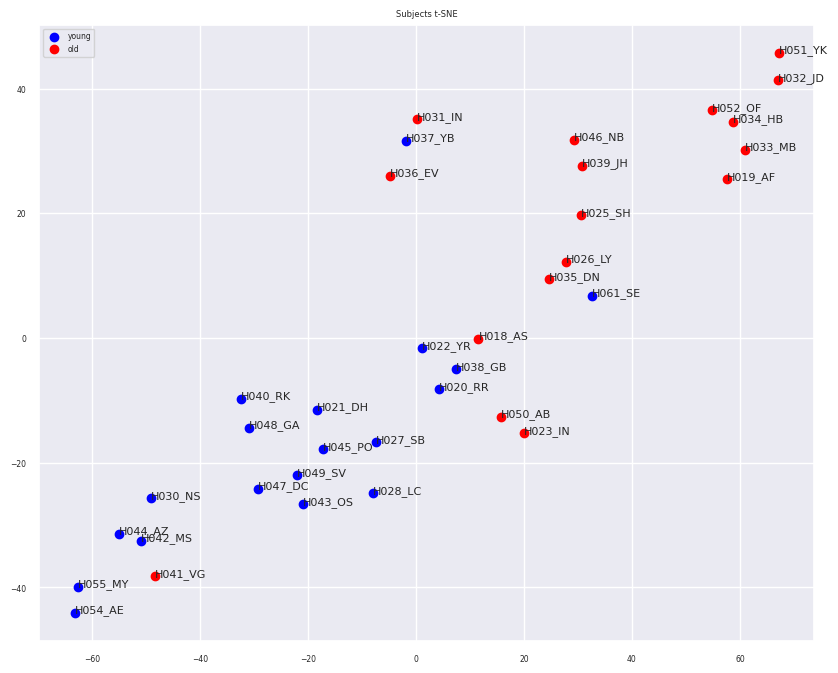

In [15]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(young_df_tsne['var_1'], young_df_tsne['var_2'], color='blue', label='young')
ax.scatter(old_df_tsne['var_1'], old_df_tsne['var_2'], color='red', label='old')

for i, txt in enumerate(young_df_tsne.index):
    ax.annotate(txt, (young_df_tsne['var_1'][i], young_df_tsne['var_2'][i]), fontsize=8)

for i, txt in enumerate(old_df_tsne.index):
    ax.annotate(txt, (old_df_tsne['var_1'][i], old_df_tsne['var_2'][i]), fontsize=8) 

plt.legend()
plt.title('Subjects t-SNE')
# plt.close()

Text(0.5, 1.0, 'Subjects t-SNE')

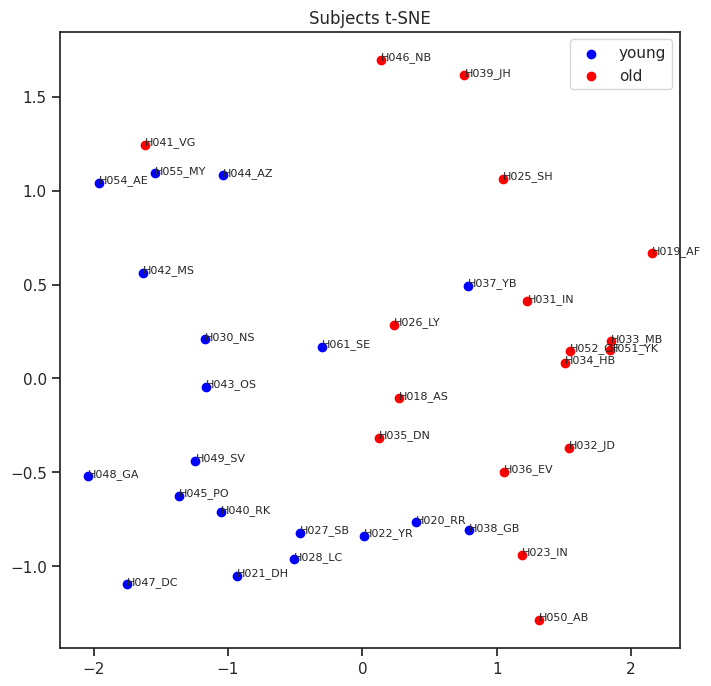

In [12]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(young_df_pca['var_1'], young_df_pca['var_2'], color='blue', label='young')
ax.scatter(old_df_pca['var_1'], old_df_pca['var_2'], color='red', label='old')

for i, txt in enumerate(young_df_pca.index):
    ax.annotate(txt, (young_df_pca['var_1'][i], young_df_pca['var_2'][i]), fontsize=8)

for i, txt in enumerate(old_df_pca.index):
    ax.annotate(txt, (old_df_pca['var_1'][i], old_df_pca['var_2'][i]), fontsize=8) 

plt.legend()
plt.title('Subjects t-SNE')
# plt.close()

In [ ]:
def tsne_cluster(config=None):
    with wandb.init(config=config):
        config=wandb.config

        tsne = TSNE(n_components=2, perplexity=config.perplexity, random_state=config.seed)
        data_reduced_tsne = reduce_dim(tsne, data_features_df)

        young_df_tsne = data_reduced_tsne.loc[young_features_df.index]
        old_df_tsne = data_reduced_tsne.loc[old_features_df.index]

        fig, ax = plt.subplots(figsize=(10,8))
        ax.scatter(young_df_tsne['var_1'], young_df_tsne['var_2'], color='blue', label='young')
        ax.scatter(old_df_tsne['var_1'], old_df_tsne['var_2'], color='red', label='old')

        for i, txt in enumerate(young_df_tsne.index):
            ax.annotate(txt, (young_df_tsne['var_1'][i], young_df_tsne['var_2'][i]), fontsize=8)

        for i, txt in enumerate(old_df_tsne.index):
            ax.annotate(txt, (old_df_tsne['var_1'][i], old_df_tsne['var_2'][i]), fontsize=8) 

        plt.legend()
        plt.title(f'Subjects t-SNE perplexity {config.perplexity}')
        wandb.log({f'results': wandb.Image(plt)})
        plt.close()

config = {
    "method": "grid",
    "parameters": {
        "perplexity": {"values": list(range(1, 30))},
        "seed": {"values": [0, 42, 38, 12, 10, 3, 2]}
    }
}

sweep_id = wandb.sweep(sweep=config, project="tsne_optimize")
wandb.agent(sweep_id, function=tsne_cluster)

In [20]:
def cluster(data, title, linkage_metric, metric='euclidean', fig_size=(8, 4)):
    dist = pdist(data, metric=metric)
    distance_matrix = pd.DataFrame(squareform(dist), index=data.index, columns=data.index)

    clusters = linkage(distance_matrix, method=linkage_metric)
    PlotsManager.create_and_plot_dendrogram(clusters, data.index,
                                                                title, linkage_metric, None, figsize=fig_size)


/tmp/ipykernel_3513349/2920028741.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(distance_matrix, method=linkage_metric)


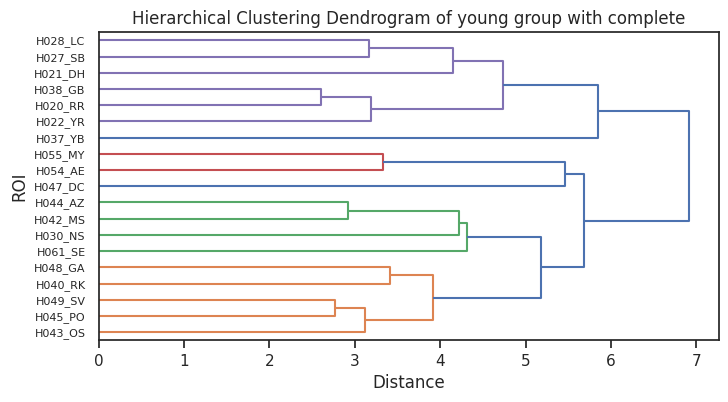

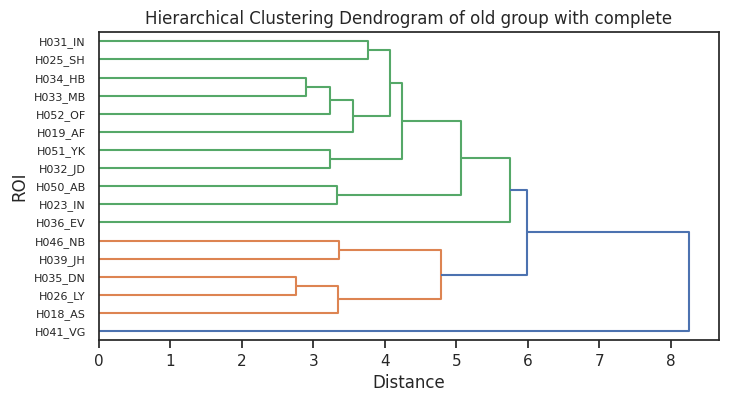

In [101]:
linkage_metric = 'complete'
fig_size=(8, 4)

cluster(young_df_pca, 'young', linkage_metric)
cluster(old_df_pca, 'old', linkage_metric)

Rois clustering

In [31]:
columns_to_keep = params_to_work_with
all_features_df = chosen_data_z_score[columns_to_keep]
young_features_df = young_subjects_z_score[columns_to_keep]
old_features_df = old_subjects_z_score[columns_to_keep]

young_features_df.index = young_subjects_z_score.subjects
old_features_df.index = old_subjects_z_score.subjects
all_features_df.index = chosen_data_z_score.subjects

In [32]:
young_features_df

,r1,tv,r2s,mt,t2,diffusion_fa,diffusion_md
subjects,,,,,,,
H020_RR,-0.151485,-0.081837,-0.247244,0.357798,-0.379060,0.023818,-0.285316
H020_RR,-0.344724,-0.521727,-0.216850,-0.266670,-0.176868,-0.204436,-0.520358
H020_RR,0.548577,0.235235,-0.050076,0.372072,-0.368418,-0.339521,-0.335374
H020_RR,0.048776,0.167665,-0.049333,0.353154,-0.315210,-0.100017,-0.325890
H020_RR,0.065722,-0.104208,-0.170523,-0.003844,-0.272643,-0.321260,-0.247017
...,...,...,...,...,...,...,...
H061_SE,0.150222,-0.080162,-0.247585,-0.252247,-0.142579,-0.320808,-0.374750
H061_SE,-0.044131,-0.081247,-0.259785,-0.416529,-0.177138,-0.274901,-0.289775
H061_SE,-0.003106,0.019280,-0.214416,0.379381,-0.246255,-0.093985,-0.272261


In [54]:
model = TSNE(n_components=2, perplexity=30, random_state=42)
# model = PCA(n_components=2)
young_df_reduced = reduce_dim(model, young_features_df, 2)
old_df_reduced = reduce_dim(model, old_features_df, 2)
all_df_reduced = reduce_dim(model, all_features_df, 2)

In [ ]:
fig = plt.figure(figsize=(25,20))

sns.scatterplot(
    x="var_1", y="var_2",
    hue=chosen_data_z_score['ROI_name'],
    palette=sns.color_palette("husl", 52),
    data=all_df_reduced,
    legend="full",
    )

In [ ]:
fig = plt.figure(figsize=(20,20))

sns.scatterplot(
    x="var_1", y="var_2",
    hue=young_subjects_z_score['ROI_name'],
    palette=sns.color_palette("husl", 52),
    data=young_df_reduced,
    legend="full",
    )

In [ ]:
fig = plt.figure(figsize=(20,20))

sns.scatterplot(
    x="var_1", y="var_2",
    hue=old_subjects_z_score['ROI_name'],
    palette=sns.color_palette("husl", 52),
    data=old_df_reduced,
    legend="full",
    )